## Customer survival analysis based on customer bank account data

In [50]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import math

In [16]:
data=pd.read_csv("checking_accounts.txt",sep="\t",index_col=None)

In [17]:
data.columns

Index(['week', 'DDA_OPEN', 'censor', 'MAIL', 'EMAIL', 'PHONE_IN', 'PHONE_OUT',
       'STORE', 'ONLINE', 'W01', 'W02', 'W03', 'W04', 'W05', 'W06', 'W07',
       'W08', 'W09', 'W10', 'W11', 'W12', 'CUSTID'],
      dtype='object')

In [18]:
data=data[['CUSTID','week','DDA_OPEN','censor','W01', 'W02', 'W03', 'W04', 'W05', 'W06', 'W07',
       'W08', 'W09', 'W10', 'W11', 'W12','MAIL', 'EMAIL', 'PHONE_IN', 'PHONE_OUT','STORE', 'ONLINE']]

### Background and Variables of interest
The banking dataset contains 52,725 customers tracked over a period of 12 weeks. 
The bank is interested in getting its customers to open up checking accounts.
They launch a marketing campaign for 12 weeks to target brand new customers at the bank. None of the customers in the sample have a checking account. 

The bank sends each customer an offer, promising to give customers $100 if they open up an account. The bank sends these offers to customers through different channels (e.g. mail, phone, in person etc.) and over different time periods. The campaign lasts 12 weeks.

##### The variables include:
* MAIL: Contact customer with offer by mail 
* EMAIL: Contact by email
* PHONE_OUT: Telemarketing phone call to customer
* PHONE_IN: Inbound call: customer first calls the phone bank, then gets offer while on the call
* STORE: Offer made to customer in person while in the branch
* ONLINE: Online banking offer made via PC or mobile banking app
* Week: The week number (goes from 1 to 12)
* CUSTID: A unique customer ID number
* Censor: Did the customer NOT open up an account by the end of the 12 weeks OR the customer drop out of the sample, for example, we don't get to follow up the customer for some reason  (1 = yes, the customer didn’t open up an account)
* W01 – W12: Dummy variables flagging the week each data row corresponds to
* DDA_OPEN: Equals 1 in the time period where the customer opened a checking account or 0 otherwise


In [24]:
data.head(27)

,CUSTID,week,DDA_OPEN,censor,W01,W02,W03,W04,W05,W06,...,W09,W10,W11,W12,MAIL,EMAIL,PHONE_IN,PHONE_OUT,STORE,ONLINE
0,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,3,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,4,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1,5,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,1,6,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,1,7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,9,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
9,1,10,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In the above data, we can see that customer 1 opened the account in week 11, customer 2 didn't opened the account during the whole 12 weeks period, cusomer 3 and 4 opened the account in week 2.

#### Build a logistic regression model 
With dependent variable as DDA_OPEN, independent variable as W01-W12

In [33]:
X=data[['W01', 'W02', 'W03', 'W04', 'W05', 'W06', 'W07','W08', 'W09', 'W10', 'W11', 'W12','PHONE_OUT']]
y=data['DDA_OPEN']

Be sure to suppress the overall intercept in the model because the weekly dummy variables replace the intercept (We are estimating a separate intercept for each week, instead of estimating one overall intercept in the model)


In [71]:
logmodel = LogisticRegression(fit_intercept=False)
logmodel.fit(X,y)
original_variables = X.columns
model_coefficients = logmodel.coef_[0]

In [72]:
coefficient_df = pd.DataFrame({"Variable" : original_variables, "Coefficient": model_coefficients})

print(coefficient_df)

     Variable  Coefficient
0         W01    -3.322414
1         W02    -3.380166
2         W03    -3.300016
3         W04    -3.023851
4         W05    -2.778651
5         W06    -2.670776
6         W07    -2.800212
7         W08    -2.699881
8         W09    -2.636232
9         W10    -2.552595
10        W11    -2.583236
11        W12    -2.861221
12  PHONE_OUT     0.538554


#### Calculate hazard probability 
calculate hazard probability with coefficient of each week and PHONE_OUT

In [73]:
logit_hazard_0call=model_coefficients[0:12]
logit_hazard_1call=model_coefficients[0:12]+0.538554 # coefficient of PHONE_OUT variable
logit_hazard_2call=model_coefficients[0:12]+0.538554*2 # coefficient of PHONE_OUT variable*2

In [74]:
hazard=pd.DataFrame({"Variable" : original_variables[0:12], "Coefficient": model_coefficients[0:12],"logit hazard with 0 call":logit_hazard_0call,
             "logit hazard with 1 call":logit_hazard_1call,"logit hazard with 2 call":logit_hazard_2call})

In [75]:
pro=hazard[["Coefficient","logit hazard with 0 call","logit hazard with 1 call","logit hazard with 2 call"]].astype(float)
week=hazard["Variable"]

In [76]:
hazard_pro=pd.concat([week,pro],axis=1)

In [78]:
# define a function to transform coefficient to probability
def to_pro(num):
    return math.exp(num)/(math.exp(num)+1)

In [79]:
hazard['hazard pro with 0 call']=hazard["logit hazard with 0 call"].apply(to_pro)
hazard['hazard pro with 1 call']=hazard["logit hazard with 1 call"].apply(to_pro)
hazard['hazard pro with 2 call']=hazard["logit hazard with 2 call"].apply(to_pro)

In [80]:
hazard_pro=hazard[["Variable",'hazard pro with 0 call','hazard pro with 1 call', 'hazard pro with 2 call']]

In [81]:
hazard_pro

,Variable,hazard pro with 0 call,hazard pro with 1 call,hazard pro with 2 call
0,W01,0.034810,0.058203,0.095755
1,W02,0.032921,0.055117,0.090870
2,W03,0.035571,0.059443,0.097712
3,W04,0.046360,0.076895,0.124909
4,W05,0.058489,0.096207,0.154264
5,W06,0.064720,0.106004,0.168868
6,W07,0.057313,0.094349,0.151472
7,W08,0.062980,0.103278,0.164823
8,W09,0.066843,0.109323,0.173772
9,W10,0.072252,0.117737,0.186110


#### Interept
If our strategy is calling customer once a week from week 5 to week 8


The probability that customer still NOT open an account at the end of week 12 will be 42.8%

In [89]:
c=1
for i in list(hazard_pro['hazard pro with 0 call'])[0:4]:
    c=c*(1-i)
for i in list(hazard_pro['hazard pro with 1 call'])[4:8]:
    c=c*(1-i)
for i in list(hazard_pro['hazard pro with 0 call'])[8:]:
    c=c*(1-i)
print(c)

0.42890277358842505


### Strategy

<AxesSubplot:>

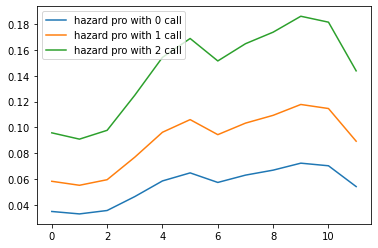

In [91]:
hazard_pro[['hazard pro with 0 call','hazard pro with 1 call', 'hazard pro with 2 call']].plot()

From this plot we can see there is three peaks in the plot week 6,8 and 9.


Based on our experience and labor capacity:
* Calling customer too many times will result in diminishing returns
* We don't have the labor to call so many customer every week

Calling customer twice in week 6 and week 9, call customer once in week 8 will be reasonable.
The estimate probability of customer still NOT open the account at the end of week 12 is 38.3%,
the estimate probability of customer will open the account at the end of week 12 is 62.7%

In [115]:

l=[i for i in list(hazard_pro['hazard pro with 0 call'])[0:5]]
l.append(hazard_pro['hazard pro with 2 call'][5])
l.append(hazard_pro['hazard pro with 0 call'][6])
l.append(hazard_pro['hazard pro with 1 call'][7])
l.append(hazard_pro['hazard pro with 2 call'][8])
l.extend(list(hazard_pro['hazard pro with 0 call'])[9:])

In [116]:
l

[0.034810199536477654,
 0.032921095765472926,
 0.03557063497739874,
 0.046359934556473664,
 0.05848882475665212,
 0.16886848428243306,
 0.05731272866578626,
 0.10327753715243632,
 0.17377231234513432,
 0.0722523381592752,
 0.07022515000920944,
 0.05410418866210293]

In [117]:
c=1
for i in l:
    c=c*(1-i)
print(c)

0.3828257830718794
